In [9]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from lib import Compressors
import torch
import matplotlib.pyplot as plt
import tqdm


In [10]:
def hilbert_matrix(n, m):
    i = torch.arange(n, dtype=torch.float64).reshape(-1, 1)
    j = torch.arange(m, dtype=torch.float64).reshape(1, -1)
    H = 1.0 / (i + j + 1)
    return H.float()

In [11]:
m = 100
sizes = [16, 50, 80, 100, 120, 150, 200, 250, 300, 400, 450, 500, 2000]
r = 8
k = 500

def clc(m, n, k):
    orig = [0, 0]
    our = [0, 0]
    for _ in range(k):
        W = torch.randn((m, n)).to('cuda')
        X = hilbert_matrix(n, n).to('cuda')
        
        A, B = Compressors.COTAN(W, X, r)
        T = A @ B
        our[0] += torch.norm(T) / k
        our[1] += torch.norm(W @ X - T @ X) / k

        A, B = Compressors.COTAN_BAD(W.to('cuda'), X, r)
        T = A @ B
        orig[0] += torch.norm(T) / k
        orig[1] += torch.norm(W @ X - T @ X) / k
        
    return orig, our

results_orig = []
results_our = []

for size in tqdm.tqdm(sizes):
    orig, our = clc(m, size, k)
    results_orig.append(orig)
    results_our.append(our)

100%|██████████| 13/13 [05:16<00:00, 24.32s/it]


In [12]:
orig_norms = [result[0].cpu() for result in results_orig]
orig_errors = [result[1].cpu() for result in results_orig]
our_norms = [result[0].cpu() for result in results_our]
our_errors = [result[1].cpu() for result in results_our]

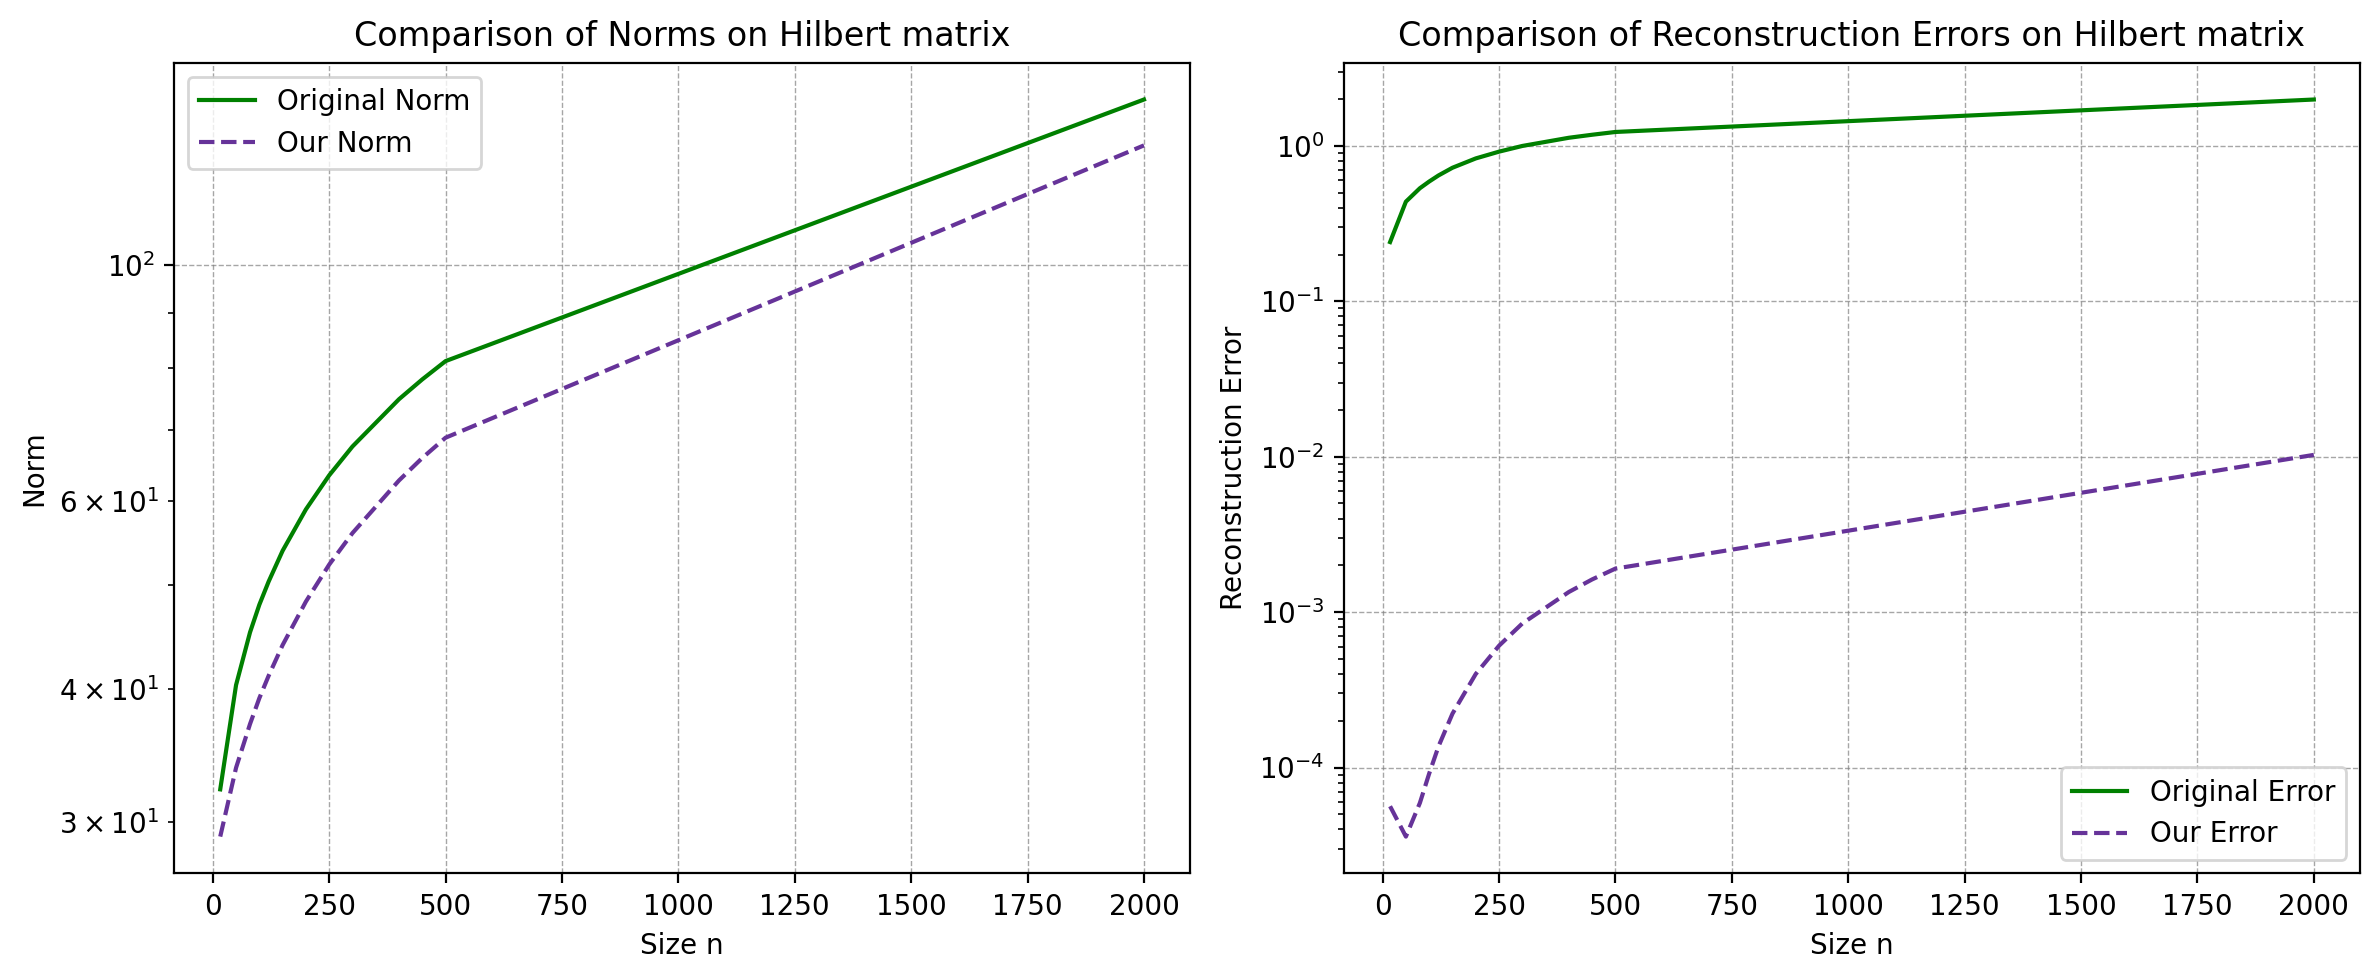

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
log_scale = True

color_B = 'rebeccapurple'
color_A = 'green'

if log_scale:
    axes[0].semilogy(sizes, orig_norms, label='Original Norm', color=color_A)
    axes[0].semilogy(sizes, our_norms, label='Our Norm', linestyle='--', color=color_B)
else:
    axes[0].plot(sizes, orig_norms, label='Original Norm', color=color_A)
    axes[0].plot(sizes, our_norms, label='Our Norm', linestyle='--', color=color_B)
    
axes[0].set_xlabel('Size n')
axes[0].set_ylabel('Norm')
axes[0].set_title('Comparison of Norms on Hilbert matrix')
axes[0].legend()
axes[0].grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

if log_scale:
    axes[1].semilogy(sizes, orig_errors, label='Original Error', color=color_A)
    axes[1].semilogy(sizes, our_errors, label='Our Error', linestyle='--', color=color_B)
else:
    axes[1].plot(sizes, orig_errors, label='Original Error', color=color_A)
    axes[1].plot(sizes, our_errors, label='Our Error', linestyle='--', color=color_B)
    
axes[1].set_xlabel('Size n')
axes[1].set_ylabel('Reconstruction Error')
axes[1].set_title('Comparison of Reconstruction Errors on Hilbert matrix')
axes[1].legend()
axes[1].grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

plt.tight_layout()
plt.savefig('1-orig_vs_our_hilbert.pdf', format='pdf', dpi=300)